# Optimization via classic differential evolution
The classic DE algorithm, shown in Algorithm 2 in our paper, is implemented in our own package [DifferentialEvolution](https://github.com/ShuhuaGao/DifferentialEvolution.jl). In this notebook, we demonstrate how to utilize the classic DE to estimate PV parameters for both SDM and DDM and the two datasets. Specifically, the `StdDE` used below refers to the simplest DE that implements "DE/rand/1" mutation and binomial crossover (please check Algorithm 2 in our paper).

We mainly conducted the following tasks
- Get the parameter values for all four cases obtained by DE in a typical run.
- Visualize the I-V curve with the parameters obtained above.
- Analyze the RMSE statistics acquired by DE for each case in 30 independent runs.
- Measure the running time of DE in each case using a fine-grained benchmark tool called [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl).

Note that the language Julia uses a just-in-time (JIT) compiler. Thus, the *first* call of a function is generally slower due to precompilation and cannot reflect the true speed. [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl) handles this situation and gives accurate runtime.

## Import required packages and set up the environment

In [1]:
using Pkg
Pkg.status()  # check current environment's status

Status `E:\GitHub\rePVest\DE\Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [336ed68f] CSV v0.7.7
  [1e3681a4] DifferentialEvolution v0.1.0 `https://github.com/ShuhuaGao/DifferentialEvolution.jl#master`
  [91a5bcdd] Plots v1.8.0
  [bd369af6] Tables v1.2.0
  [de0858da] Printf
  [9a3f8284] Random
  [10745b16] Statistics


In [2]:
using Plots
using BenchmarkTools
using Random, Printf
using CSV, Tables
using Statistics
using DifferentialEvolution

In [3]:
versioninfo()

Julia Version 1.5.0
Commit 96786e22cc (2020-08-01 23:44 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-3770 CPU @ 3.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, ivybridge)
Environment:
  JULIA_NUM_THREADS = 4


In [4]:
# seed to reproduce our exact result
# comment it and each run may generate a slightly different result
Random.seed!(123);  

In [5]:
# directory to store images: change it to your own one
const img_dir = raw"F:\OneDrive - National University of Singapore\PaperWork\microgrid\PV-ID\community\img";

## Read data

In [6]:
const data_RT = CSV.File("data/RTFrance.csv") |> Tables.matrix;
const data_PW = CSV.File("data/Photowatt25.csv") |> Tables.matrix
@show size(data_RT)
@show size(data_PW);

size(data_RT) = (26, 2)
size(data_PW) = (25, 2)


## Set temperatures, search ranges, and import related functions

In [7]:
const T_RT = 33 + 273.15  # temperature in Kalvin of the RTC France case
const T_PW = 45 + 273.15;  # temperature in Kalvin of the Photowatt case

In [8]:
# see Table 1 in our paper
const bounds_RT_sdm = Float64[0 1; 0 1; 1 2; 0 0.5; 0 100];
const bounds_RT_ddm = Float64[0 1; 0 1; 0 1; 1 2; 1 2; 0 0.5; 0 100]; 
const bounds_PW_sdm = Float64[0 2; 0 50; 1 50; 0 2; 0 2000]; 
const bounds_PW_ddm = Float64[0 2; 0 0.01; 0 50; 1 50; 1 50; 0 2; 0 2000];

In [9]:
include("models.jl")  # import related functions

calculate_rmse

## Function to obtain the statistics of RMSE for DE
Run the DE 30 times, and record the RMSE statistics

In [10]:
const ntrials = 30;

In [11]:
"""
    measure_rmse_stats(model::Function, data, T, bounds, np, F, Cr, G)

Measure the RMSE statistics in multiple runs of DE.

- model: `model_sdm` or `model_ddm`
- data: PV data
- T: PV temperature in Kalvin
- bounds: search range of parameters
- np, F, Cr, G: DE control parameters
"""
function measure_rmse_stats(model::Function, data, T, bounds, np, F, Cr, G)
    sse_evaluator(θ) = calculate_sse(data, (V, I) -> model(V, I, θ..., T))
    records = zeros(ntrials)
    for i = 1:ntrials
        de = StdDE(np, bounds, StdOptions(F, Cr); senses=-1)
        evolve!(de, sse_evaluator, G; stats=[])
        rmse = sqrt(best_fitness(de) / size(data, 1))
        records[i] = rmse
    end
    return Dict(
        :min => minimum(records),
        :mean => mean(records),
        :max => maximum(records),
        :std => std(records)
    )
end

measure_rmse_stats

## SDM results

In [12]:
const np = 50  # number of individuals
const F = 0.6
const Cr = 0.9
const G_sdm = 800 # number of generations
const G_ddm = 1600 # number of generations
;

### RTC France

In [13]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_RT, (V, I) -> model_sdm(V, I, θ..., T_RT));

- A typical run

In [14]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_RT_sdm, StdOptions(F, Cr); senses=-1)  # minimization
evolve!(de, evaluator, G_sdm; stats=[:best, :std])  # show the best fitness and the standard deviation among population's fitness

gen  	best      	std       	
0    	2.96303e-01	6.53732e+09	
1    	2.96303e-01	6.80748e+06	
2    	2.96303e-01	4.37886e+04	
3    	2.96303e-01	2.79317e+02	
4    	1.40455e-01	5.84366e+01	
5    	1.40455e-01	1.24837e+00	
6    	1.40455e-01	1.08082e+00	
7    	1.40455e-01	9.86620e-01	
8    	1.40455e-01	1.00198e+00	
9    	1.40455e-01	7.80878e-01	
10   	1.40455e-01	6.04964e-01	
11   	4.98401e-02	4.57947e-01	
12   	3.37695e-02	3.03963e-01	
13   	7.37070e-03	2.20041e-01	
14   	7.37070e-03	1.43737e-01	
15   	7.37070e-03	1.39585e-01	
16   	7.37070e-03	1.15058e-01	
17   	1.99109e-03	1.13709e-01	
18   	1.99109e-03	8.73509e-02	
19   	1.99109e-03	8.51623e-02	
20   	1.99109e-03	3.23115e-02	
21   	1.55525e-03	2.70219e-02	
22   	1.55525e-03	2.09126e-02	
23   	1.55525e-03	1.98370e-02	
24   	1.55525e-03	1.91521e-02	
25   	4.04821e-04	1.41122e-02	
26   	4.04821e-04	1.15743e-02	
27   	4.04821e-04	1.14855e-02	
28   	4.04821e-04	1.00663e-02	
29   	8.48684e-05	7.53228e-03	
30   	8.48684e-05	4.97802e-03	
31   	8.48

In [15]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
best_rmse = sqrt(best_sse / size(data_RT, 1))
@printf("Min RMSE (SDM + RTC France) = %.5e", best_rmse)

Min RMSE (SDM + RTC France) = 9.86022e-04

In [16]:
println("Best parameter values (SDM + RTC France):")
best = best_individual(de)

Best parameter values (SDM + RTC France):


5-element Array{Float64,1}:
  0.7607755302381982
  0.3230208116626384
  1.4811835905738695
  0.03637709269660183
 53.71852446346177

- Visualization

In [17]:
I_RT_SDM = [model_sdm(V, I, best..., T_RT) for (V, I) in eachrow(data_RT)];

In [18]:
p_RT = plot(size=(400, 300), labelfontsize=10)
plot!(p_RT, data_RT[:, 1], data_RT[:, 2]; st=:scatter, label="Measurement");
plot!(p_RT, data_RT[:, 1], I_RT_SDM; label="SDM");

- RMSE statistics

In [19]:
println("RMSE statistics in $ntrials runs (SDM + RTC France):")
measure_rmse_stats(model_sdm, data_RT, T_RT, bounds_RT_sdm, np, F, Cr, G_sdm)

RMSE statistics in 30 runs (SDM + RTC France):


Dict{Symbol,Float64} with 4 entries:
  :max  => 0.000986022
  :std  => 4.39298e-17
  :mean => 0.000986022
  :min  => 0.000986022

- Measure average runtime

In [20]:
println("Measure the running time (SDM + RTC France):")
@benchmark begin
    de = StdDE(np, bounds_RT_sdm, StdOptions(F, Cr); senses=-1)
    evolve!(de, evaluator, G_sdm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (SDM + RTC France):


BenchmarkTools.Trial: 
  memory estimate:  176.47 MiB
  allocs estimate:  10467356
  --------------
  minimum time:     320.064 ms (3.75% GC)
  median time:      323.392 ms (3.81% GC)
  mean time:        327.921 ms (3.81% GC)
  maximum time:     406.313 ms (3.11% GC)
  --------------
  samples:          30
  evals/sample:     1

### Photowatt-PWP201

In [21]:
# given a parameter vector θ, compute its SSE as the fitness in DE
# note that the temperature of the two datasets are different
evaluator(θ) = calculate_sse(data_PW, (V, I) -> model_sdm(V, I, θ..., T_PW));

- A typical run

In [22]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_PW_sdm, StdOptions(F, Cr); senses=-1)  # minimization
@time evolve!(de, evaluator, G_sdm; stats=[:best, :std])

gen  	best      	std       	
0    	2.71062e+00	2.07171e+130	
1    	2.71062e+00	1.91823e+23	
2    	2.71062e+00	1.89414e+08	
3    	1.97408e+00	4.38187e+06	
4    	9.97365e-01	5.30796e+03	
5    	9.97365e-01	4.43768e+02	
6    	4.43520e-01	3.14200e+01	
7    	2.49464e-01	1.34415e+01	
8    	2.03286e-01	4.33788e+00	
9    	2.56221e-02	2.05423e+00	
10   	2.56221e-02	1.74066e+00	
11   	7.36309e-03	9.69301e-01	
12   	7.36309e-03	4.89774e-01	
13   	7.36309e-03	2.61035e-01	
14   	7.36309e-03	2.40282e-01	
15   	7.36309e-03	1.63385e-01	
16   	7.36309e-03	1.37853e-01	
17   	7.36309e-03	1.22933e-01	
18   	7.36309e-03	9.82691e-02	
19   	7.36309e-03	4.80455e-02	
20   	5.13360e-03	3.66984e-02	
21   	2.20647e-03	3.25944e-02	
22   	1.98665e-03	2.87184e-02	
23   	1.98665e-03	2.50584e-02	
24   	1.98665e-03	2.12787e-02	
25   	4.73600e-04	1.93572e-02	
26   	4.73600e-04	1.94195e-02	
27   	4.73600e-04	1.90932e-02	
28   	4.73600e-04	1.32540e-02	
29   	4.73600e-04	1.09254e-02	
30   	4.73600e-04	1.02094e-02	
31   	4.7

In [23]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
best_rmse = sqrt(best_sse / size(data_PW, 1))
@printf("Min RMSE (SDM + Photowatt-PWP201) = %.5e", best_rmse)

Min RMSE (SDM + Photowatt-PWP201) = 2.42507e-03

In [24]:
println("Best parameter values (SDM + Photowatt-PWP201):")
best = best_individual(de)

Best parameter values (SDM + Photowatt-PWP201):


5-element Array{Float64,1}:
   1.030514299186343
   3.482262677552155
  48.64283460133695
   1.2012710168028446
 981.9822144050421

- Visualization

In [25]:
I_PW_SDM = [model_sdm(V, I, best..., T_PW) for (V, I) in eachrow(data_PW)]
p_PW = plot(data_PW[:, 1], data_PW[:, 2]; st=:scatter, label="Measurement", size=(400, 300))
plot!(p_PW, data_PW[:, 1], I_PW_SDM; label="SDM");

- RMSE statistics

In [26]:
println("RMSE statistics in $ntrials runs (SDM + Photowatt-PWP201):")
measure_rmse_stats(model_sdm, data_PW, T_PW, bounds_PW_sdm, np, F, Cr, G_sdm)

RMSE statistics in 30 runs (SDM + Photowatt-PWP201):


Dict{Symbol,Float64} with 4 entries:
  :max  => 0.00242507
  :std  => 2.95248e-17
  :mean => 0.00242507
  :min  => 0.00242507

- Measure average runtime

In [27]:
println("Measure the running time (SDM + Photowatt-PWP201):")
@benchmark begin
    de = StdDE(np, bounds_PW_sdm, StdOptions(F, Cr); senses=-1)  # minimization
    evolve!(de, evaluator, G_sdm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (SDM + Photowatt-PWP201):


BenchmarkTools.Trial: 
  memory estimate:  169.73 MiB
  allocs estimate:  10066306
  --------------
  minimum time:     311.091 ms (3.95% GC)
  median time:      316.043 ms (3.94% GC)
  mean time:        320.658 ms (3.84% GC)
  maximum time:     352.873 ms (3.27% GC)
  --------------
  samples:          30
  evals/sample:     1

## DDM results

### RTC France

In [28]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_RT, (V, I) -> model_ddm(V, I, θ..., T_RT));

- A typical run

In [29]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_RT_ddm, StdOptions(F, Cr); senses=-1)  # minimization
@time evolve!(de, evaluator, G_ddm; stats=[:best, :std])

gen  	best      	std       	
0    	2.81261e+00	1.27489e+12	
1    	1.95188e+00	1.08476e+07	
2    	7.48846e-01	3.88508e+03	
3    	7.48846e-01	2.07458e+03	
4    	3.35282e-01	1.68653e+01	
5    	3.35282e-01	3.92816e+00	
6    	3.35282e-01	1.81183e+00	
7    	3.35282e-01	6.04318e-01	
8    	7.90292e-02	6.31929e-01	
9    	7.90292e-02	5.13095e-01	
10   	6.00581e-02	5.37390e-01	
11   	6.00581e-02	4.56996e-01	
12   	3.13695e-02	4.04960e-01	
13   	2.88703e-02	3.28506e-01	
14   	2.88703e-02	2.81162e-01	
15   	1.42411e-02	2.09529e-01	
16   	1.42411e-02	1.80288e-01	
17   	1.07040e-02	1.46452e-01	
18   	4.13231e-04	1.25241e-01	
19   	4.13231e-04	9.03023e-02	
20   	4.13231e-04	6.75206e-02	
21   	4.13231e-04	5.88451e-02	
22   	4.13231e-04	5.84423e-02	
23   	4.13231e-04	5.05133e-02	
24   	4.13231e-04	4.73217e-02	
25   	4.13231e-04	4.41671e-02	
26   	4.13231e-04	4.23310e-02	
27   	4.13231e-04	3.82501e-02	
28   	4.13231e-04	2.77432e-02	
29   	4.13231e-04	2.14477e-02	
30   	4.13231e-04	2.03406e-02	
31   	4.13

In [30]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
best_rmse = sqrt(best_sse / size(data_RT, 1))
@printf("Min RMSE (DDM + RTC France) = %.5e", best_rmse)

Min RMSE (DDM + RTC France) = 9.82485e-04

In [31]:
println("Best parameter values (DDM + RTC France):")
best = best_individual(de)

Best parameter values (DDM + RTC France):


7-element Array{Float64,1}:
  0.7607810793272737
  0.22597464839943407
  0.7493440926486831
  1.451016905775964
  1.9999999999937612
  0.036740428350323234
 55.48542771449805

- Visualization

In [32]:
I_RT_DDM = [model_ddm(V, I, best..., T_RT) for (V, I) in eachrow(data_RT)];

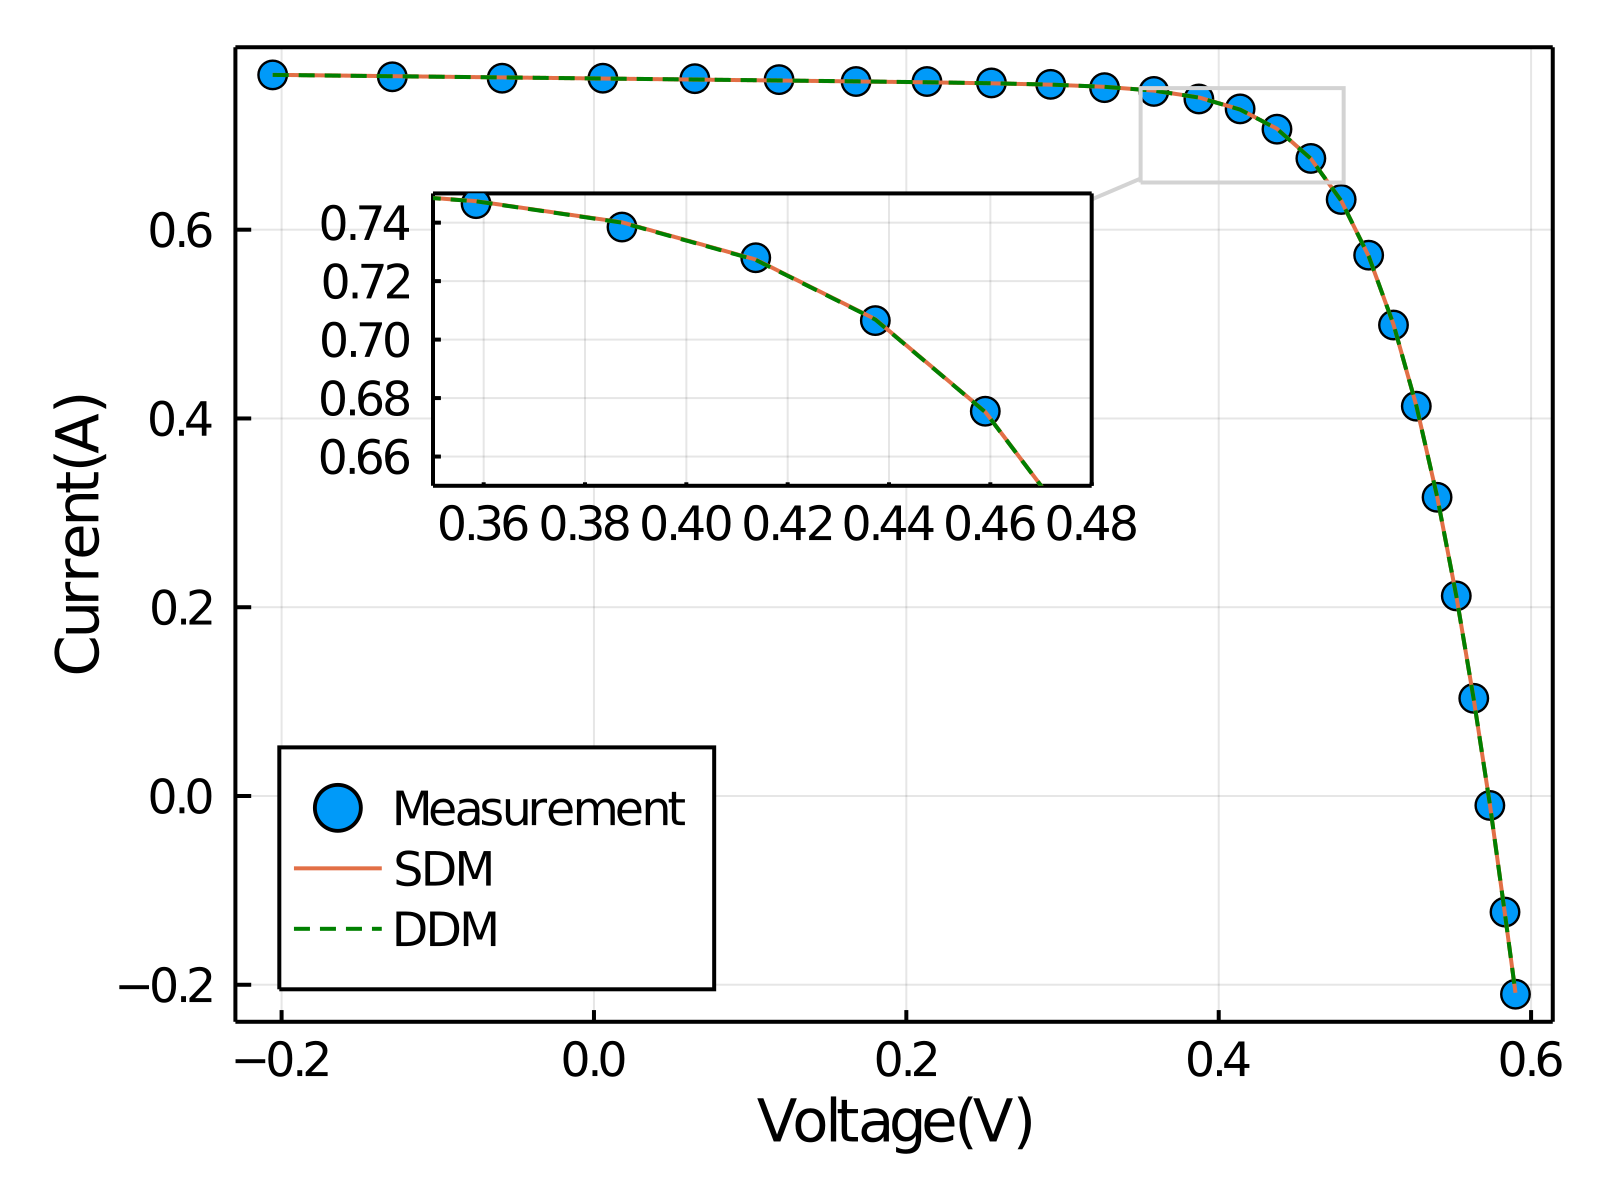

In [33]:
# continue the plot `p_RT`
plot!(p_RT, data_RT[:, 1], I_RT_DDM; label="DDM", linestyle=:dash, linecolor=:green)
plot!(p_RT; legend=:bottomleft, xlabel="Voltage(V)", ylabel="Current(A)", framestyle=:box)
lens!(p_RT, [0.35, 0.48], [0.65, 0.75], inset=(1, bbox(0.15, 0.15, 0.5, 0.3)), framestyle=:box)
savefig(p_RT, joinpath(img_dir, "DE_RT.pdf"))
p_RT  # display it here

- RMSE statistics

In [34]:
println("RMSE statistics in $ntrials runs (DDM + RTC France):")
measure_rmse_stats(model_ddm, data_RT, T_RT, bounds_RT_ddm, np, F, Cr, G_ddm)

RMSE statistics in 30 runs (DDM + RTC France):


Dict{Symbol,Float64} with 4 entries:
  :max  => 0.000986022
  :std  => 7.10277e-7
  :mean => 0.000982676
  :min  => 0.000982485

- Measure average runtime

In [35]:
println("Measure the running time (DDM + RTC France):")
@benchmark begin
    de = StdDE(np, bounds_RT_ddm, StdOptions(F, Cr); senses=-1)
    evolve!(de, evaluator, G_ddm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (DDM + RTC France):


BenchmarkTools.Trial: 
  memory estimate:  415.93 MiB
  allocs estimate:  25075160
  --------------
  minimum time:     760.572 ms (3.54% GC)
  median time:      775.160 ms (3.78% GC)
  mean time:        781.729 ms (3.73% GC)
  maximum time:     841.223 ms (3.45% GC)
  --------------
  samples:          30
  evals/sample:     1

### Photowatt-PWP201

In [36]:
# given a parameter vector θ, compute its SSE as the fitness in DE
evaluator(θ) = calculate_sse(data_PW, (V, I) -> model_ddm(V, I, θ..., T_PW));

- A typical run

In [37]:
# each run is new due to the involved randomness
de = StdDE(np, bounds_PW_ddm, StdOptions(F, Cr); senses=-1)  # minimization
evolve!(de, evaluator, G_ddm; stats=[:best, :std])

gen  	best      	std       	
0    	2.54860e+00	NaN       	
1    	2.54860e+00	Inf       	
2    	1.29592e+00	7.21034e+87	
3    	1.29592e+00	1.66358e+17	
4    	9.76098e-01	6.51835e+07	
5    	9.76098e-01	1.53199e+05	
6    	6.11478e-01	4.13913e+02	
7    	3.62694e-01	1.44283e+02	
8    	1.93205e-01	2.36863e+01	
9    	1.93205e-01	5.74927e+00	
10   	1.93205e-01	3.61750e+00	
11   	1.17212e-01	2.99455e+00	
12   	7.10595e-02	1.94047e+00	
13   	3.61786e-02	1.55440e+00	
14   	3.61786e-02	8.13144e-01	
15   	3.61786e-02	5.51701e-01	
16   	1.52011e-02	3.38909e-01	
17   	1.52011e-02	2.27373e-01	
18   	1.52011e-02	1.42002e-01	
19   	2.48944e-03	9.26237e-02	
20   	2.48944e-03	7.03446e-02	
21   	2.48944e-03	5.68532e-02	
22   	2.48944e-03	5.26043e-02	
23   	2.48944e-03	4.68825e-02	
24   	2.48944e-03	4.72197e-02	
25   	2.48944e-03	4.13231e-02	
26   	2.48944e-03	3.87385e-02	
27   	2.39476e-04	3.36836e-02	
28   	2.39476e-04	2.74648e-02	
29   	2.39476e-04	2.12872e-02	
30   	2.39476e-04	1.98003e-02	
31   	2.3947

In [38]:
# note that the fitness refers to the SSE
best_sse = best_fitness(de)
@printf("sse = %e\n", best_sse)
best_rmse = sqrt(best_sse / size(data_PW, 1))
@printf("Min RMSE (DDM + Photowatt-PWP201) = %.5e", best_rmse)

sse = 1.470247e-04
Min RMSE (DDM + Photowatt-PWP201) = 2.42507e-03

In [39]:
println("Best parameter values (DDM + Photowatt-PWP201):")
best = best_individual(de)

Best parameter values (DDM + Photowatt-PWP201):


7-element Array{Float64,1}:
   1.0305142996070542
   0.009777911024527599
   3.472485130456161
  48.642840584573555
  48.642834994788174
   1.2012710035839025
 981.9821812467368

- Visualization

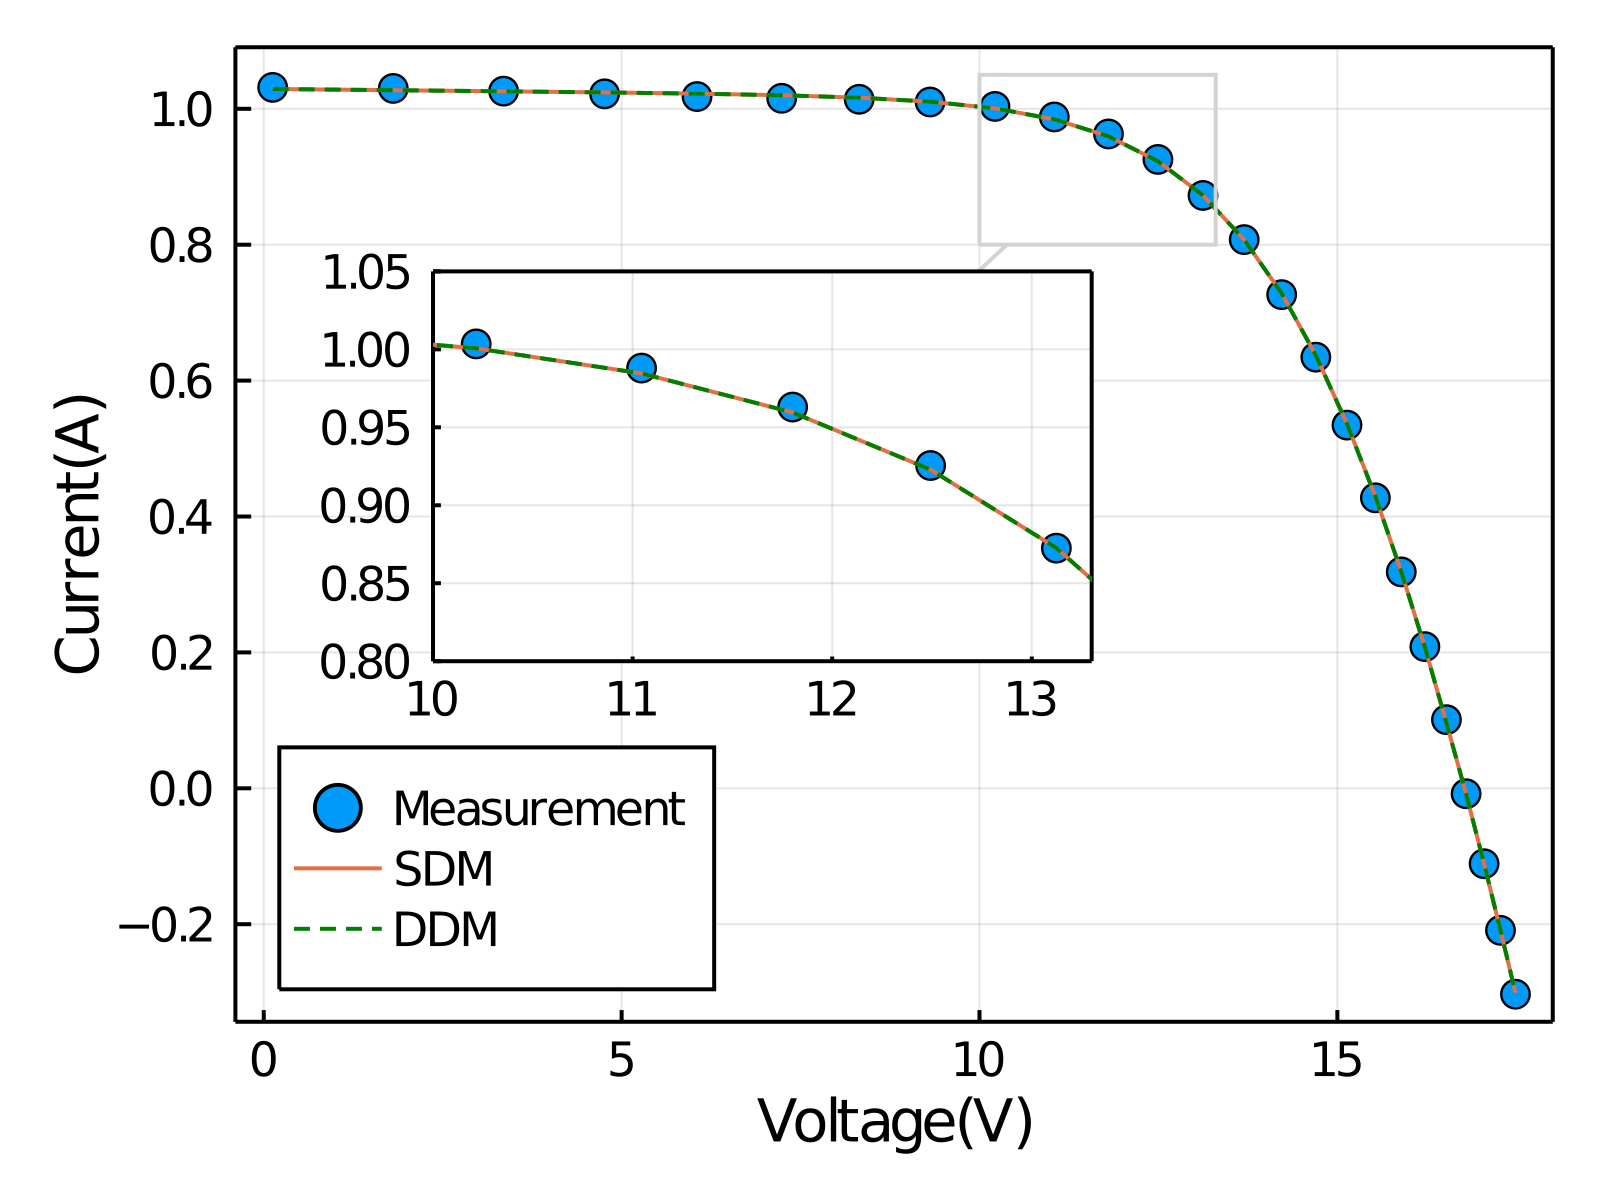

In [40]:
I_PW_DDM = [model_ddm(V, I, best..., T_PW) for (V, I) in eachrow(data_PW)];
plot!(p_PW, data_PW[:, 1], I_PW_DDM; label="DDM", linestyle=:dash, linecolor=:green)
plot!(p_PW; legend=:bottomleft, xlabel="Voltage(V)", ylabel="Current(A)", framestyle=:box, labelfontsize=10)
lens!(p_PW, [10, 13.3], [0.8, 1.05], inset=(1, bbox(0.15, 0.23, 0.5, 0.4)), framestyle=:box)
savefig(p_PW, joinpath(img_dir, "DE_PW.pdf"))
p_PW # also display here

- RMSE statistics

In [41]:
println("RMSE statistics in $ntrials runs (DDM + Photowatt-PWP201):")
measure_rmse_stats(model_ddm, data_PW, T_PW, bounds_PW_ddm, np, F, Cr, G_ddm)

RMSE statistics in 30 runs (DDM + Photowatt-PWP201):


Dict{Symbol,Float64} with 4 entries:
  :max  => 0.00242507
  :std  => 2.39546e-17
  :mean => 0.00242507
  :min  => 0.00242507

- Measure average runtime

In [42]:
println("Measure the running time (DDM + Photowatt-PWP201):")
@benchmark begin
    de = StdDE(np, bounds_PW_ddm, StdOptions(F, Cr); senses=-1)
    evolve!(de, evaluator, G_ddm; stats=[])
end evals=1 samples=ntrials seconds=1000

Measure the running time (DDM + Photowatt-PWP201):


BenchmarkTools.Trial: 
  memory estimate:  400.02 MiB
  allocs estimate:  24113810
  --------------
  minimum time:     728.814 ms (3.78% GC)
  median time:      744.026 ms (3.76% GC)
  mean time:        759.068 ms (3.77% GC)
  maximum time:     862.307 ms (3.23% GC)
  --------------
  samples:          30
  evals/sample:     1